# <center> Teads.tv Data Scientist Challenge </center>

###### <center> Mohammed Benseddik - benseddikmohammed@gmail.com - www.mohammed-benseddik.info </center>

In [247]:
# Option to toogle code in HTML
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html(
    '<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area"); jQuery(".prompt")}});</script>',
    raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html(
    '''<button oncl
    ick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''',
    raw=True)

Toggle code

# Context

Every time a user browses an eligible web page, we have to decide whether to display an ad video or not.
If the video is displayed, then we will incur a fixed cost. However, we will benefit from a revenue only if the video is watched a minimum number of seconds by the user.
Thus, there are three possible cases:
- We do not display the video: Cost=0, Revenue=0, Profit=0
- We display a video that is not watched long enough: Cost>0, Revenue=0, Profit=-Cost
- We display a video that is watched long enough: Cost>0, Revenue>0, Profit=Revenue-Cost

# Log description

You will find attached a csv file of 100000 examples of video ad displays. This log contains the following columns:
- creative_id: A unique identifier of the video that has been displayed to the user
- user_operating_system: The user Operating System (OS)
- user_device: The user device type
- average_seconds_played: The average number of seconds the user usually watches our videos (only if we already know the user, based on the user history)
- cost: The cost we had to pay to display the video
- revenue: The revenue generated by this video when it has been watched

In [50]:
# Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import itertools
import plotly.graph_objs as go
from IPython.display import display
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
init_notebook_mode(connected=True)
%matplotlib inline
sns.set_style("whitegrid")

In [42]:
# Data imports
path = "data/"
df = pd.read_csv(path + "aft100k.csv")

In [66]:
# Weight and Heihght of graphs
w_img = 18
h_img = 5

# Data exploration

*We will take a first look at our data, and try to derive some meaningful information about the content of our columns, missing data, the distributions of continuous columns, etc.*

In [51]:
display(df.head(10))
display(df.describe())

,creative_id,user_operating_system,user_device,average_seconds_played,cost,revenue
0,113521,Android,Phone,NaN,0.010128,0.0
1,115340,Windows,PersonalComputer,0.000000,0.005937,0.0
2,113582,Android,Phone,7.142857,0.004398,0.0
3,97385,Windows,PersonalComputer,NaN,0.006157,0.0
4,114821,Windows,PersonalComputer,NaN,0.001994,0.0
5,113065,Android,Tablet,NaN,0.003781,0.0
6,111414,iOS,Phone,17.000000,0.002836,0.0
7,111414,iOS,Phone,NaN,0.002836,0.0
8,112705,Windows,PersonalComputer,14.560606,0.006157,0.0
9,113176,macOS,PersonalComputer,0.000000,0.006157,0.0


,creative_id,average_seconds_played,cost,revenue
count,100000.00000,38172.000000,100000.000000,100000.000000
mean,112156.27350,10.601625,0.005671,0.007789
std,5255.58913,9.791514,0.003503,0.014616
min,50634.00000,0.000000,0.000473,0.000000
25%,112190.00000,3.000000,0.003308,0.000000
50%,113521.00000,9.000000,0.004837,0.000000
75%,114948.00000,16.000000,0.006616,0.013416
max,115465.00000,175.000000,0.052878,0.145641


**We can already make some assumptions by looking at the first 10 rows of our dataset :**
- *creative_id* contains **ids** that are repeated among various observations. It means that the associated video is present multiple times in the data set, and is shown to various users in the log. We can derive later some information related to the video itself, by **grouping** the observations with the same creative_id and having a look at the shared characteristics.
- We have 2 **categorical data** columns in our dataset : *user_operating_system* and *user_device*. From their description, we may think that they are highly correlated, because user devices are platforms for different user OS. It is necessary to have an idea about the distribution of each category in these 2 columns over our observations set.
- We observe that *average_seconds_played* contains **'NaN' values**. Those 'NaN' values do not describe missing data, but users whom we don't have a previous insight before. We have to handle these values carefully, because replacing those 'NaN' values with the wrong information will lead us to a **strong bias** in our dataset.
- **Cost** and **Revenue** are 2 continuous values we have in the dataframe. We would like to have a look at their distributions, and derive some insights about the tendencies of profits for each video displayed.

### >>> We will explore each point as follows :

##### 1) Insights about the videos displayed :

The number of unique videos in the log is : 936
The distribution of number of times that each video was displayed in the log : 


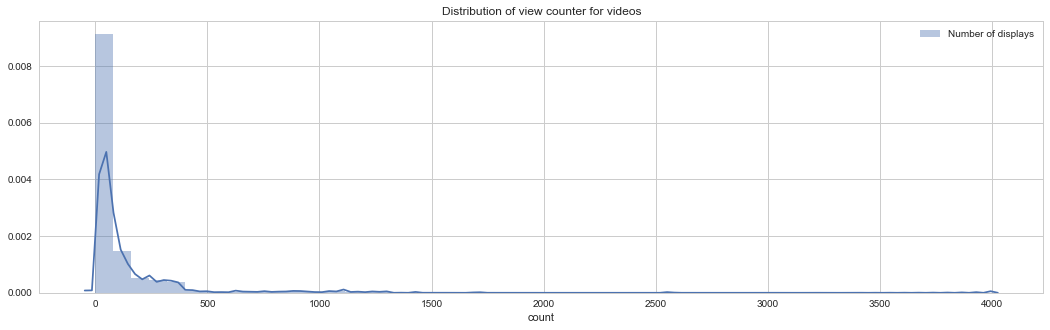

The distribution of total revenues generated per unique video: 


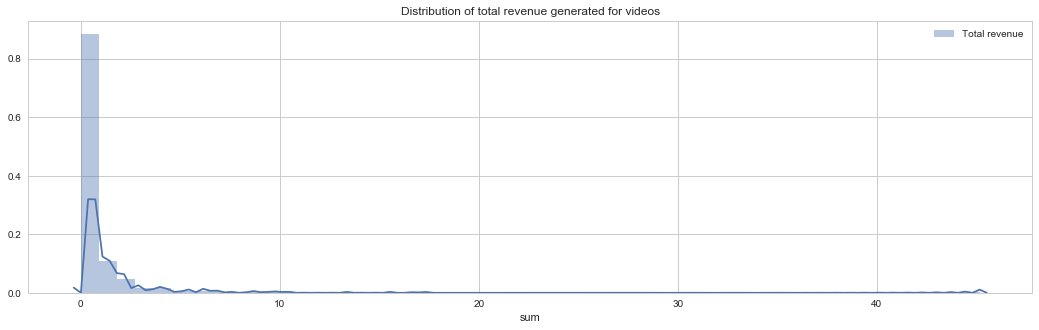

The distribution of the mean of revenue compared to the mean of cost per unique video : 


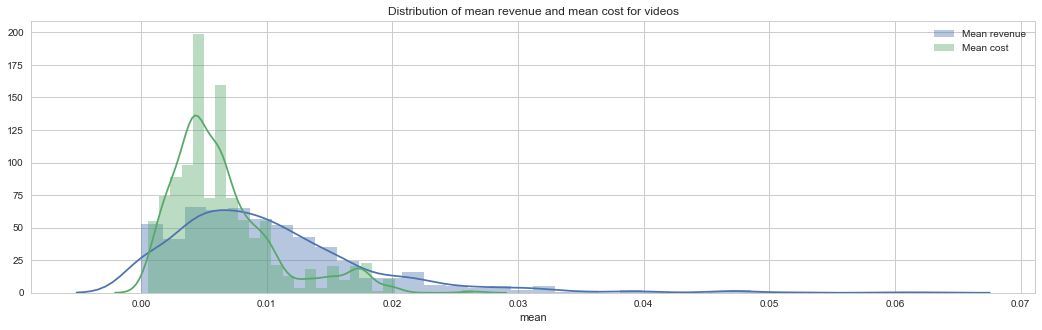

In [84]:
f = {'cost':['mean', 'count'], 'revenue':['sum', 'mean']}
videos_grouped = df.groupby('creative_id').agg(f)
print(('The number of unique videos in the log is : {}'.format(videos_grouped.shape[0])))

print('The distribution of number of times that each video was displayed in the log : ')
fig, ax = plt.subplots(figsize=(w_img, h_img))
sns.distplot(videos_grouped['cost']['count'], ax=ax, label='Number of displays');
plt.title('Distribution of view counter for videos');
plt.legend();
plt.show();

print('The distribution of total revenues generated per unique video: ')
fig, ax = plt.subplots(figsize=(w_img, h_img))
sns.distplot(videos_grouped['revenue']['sum'], ax=ax, label='Total revenue');
plt.title('Distribution of total revenue generated for videos');
plt.legend();
plt.show();

print('The distribution of the mean of revenue compared to the mean of cost per unique video : ')
fig, ax = plt.subplots(figsize=(w_img, h_img))
sns.distplot(videos_grouped['revenue']['mean'], ax=ax, label='Mean revenue');
sns.distplot(videos_grouped['cost']['mean'], ax=ax, label='Mean cost');
plt.title('Distribution of mean revenue and mean cost for videos');
plt.legend();
plt.show();

- *Videos are generally displayed for user for a small amount of times. There are though some videos that have a high number of displays.*
- *Revenues are correlated to the amount of times the video is displayed, which is normal. The range of total revenues per video is between 0 and ~50.*
- *The third distribution graph shows us clearly that there are videos that are not profitable : $mean[cost] > mean[revenue]$, and a portion of videos that tend to be profitable : $mean[cost] < mean[revenue]$, as seen with the overlapping lines of distributions.*

##### 2) Insights about categorical data :

In [85]:
print("Different Operating Systems : {}".format(df['user_operating_system']
                                                .unique()))
print("Different User Devices : {}".format(df['user_device'].unique()))

Different Operating Systems : ['Android' 'Windows' 'iOS' 'macOS' 'OS X' 'Fire OS' 'Linux' 'Chrome OS'
 'BlackBerry OS' 'unknown' 'BSD' 'RIM OS']
Different User Devices : ['Phone' 'PersonalComputer' 'Tablet' nan 'ConnectedTv']


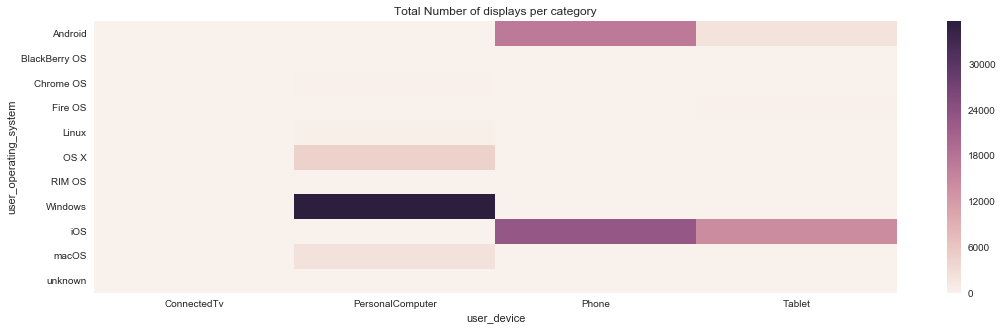

In [100]:
fig, ax = plt.subplots(figsize=(w_img, h_img))
sns.heatmap(df.groupby(['user_operating_system', 'user_device']).count()['creative_id'].unstack(fill_value=0));
plt.title("Total Number of displays per category");
plt.show();

- *The videos displayed on **PersonalComputer** and with the **Windows OS** are the most present type of videos in the log file.*
- *The **Phone** category is taking a large amount of displayed videos too, with the **IOS** being the dominant OS category.*
- *The **IOS** is present in both the **Phone** and **Tablet** platforms*.

##### 3) Insights about NaN values in the dataset  and the average_seconds_played column:

Poucentage of videos with unknown users : 61.828%, and their number in the log file is : 61828.
Poucentage of videos with known users : 38.172%, and their number in the log file is : 38172.
Total number of videos in the log : 100000.


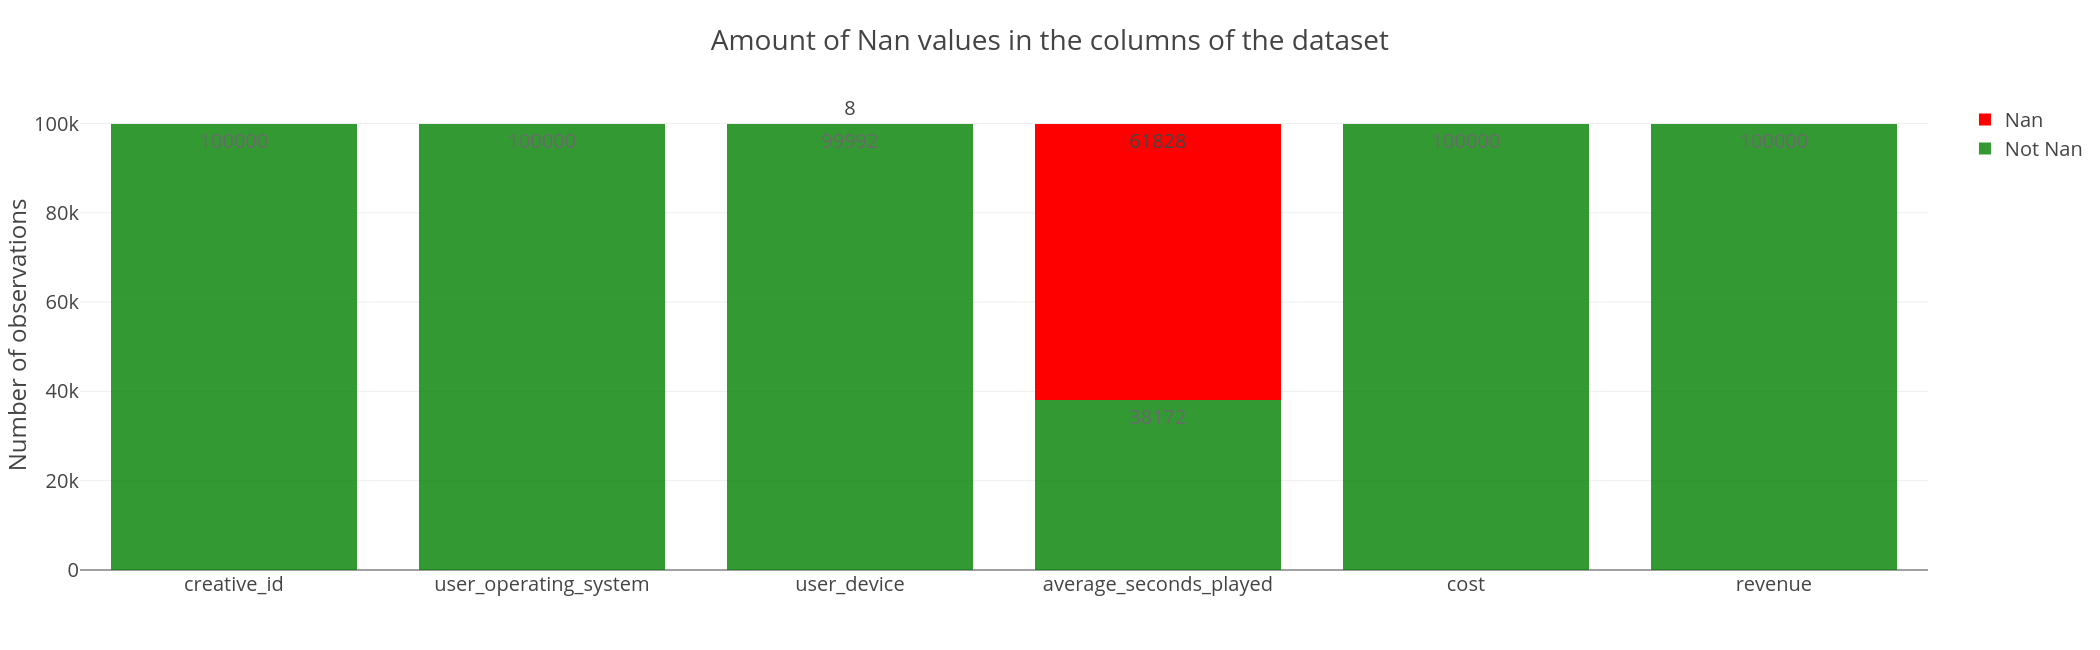

In [116]:
existing_data = df.notnull().sum()
missing_data = df.isnull().sum()

print((
    "Poucentage of videos with unknown users : {}%, and their number in the log file is : {}.".
    format(missing_data['average_seconds_played'] * 100 / df.shape[0],
           missing_data['average_seconds_played'])))
print((
    "Poucentage of videos with known users : {}%, and their number in the log file is : {}.".
    format(existing_data['average_seconds_played'] * 100 / df.shape[0],
           existing_data['average_seconds_played'])))
print(("Total number of videos in the log : {}.".format(df.shape[0])))

data = [
    go.Bar(
        x=existing_data.index,
        y=existing_data,
        name='Not Nan',
        text=existing_data,
        textposition='auto',
        marker=dict(
            color='green', ),
        opacity=0.8),
    go.Bar(
        x=missing_data.index,
        y=missing_data,
        name='Nan',
        text=missing_data,
        textposition='auto',
        marker=dict(
            color='red', ),
        opacity=1.0)
]
layout = go.Layout(
    title='Amount of Nan values in the columns of the dataset',
    barmode='stack',
    yaxis=dict(title='Number of observations'),
    font=dict(size=20),
)
fig = {'data': data, 'layout': layout}

py.image.ishow(fig, height=150 + h_img*100, width=300 + w_img*100)

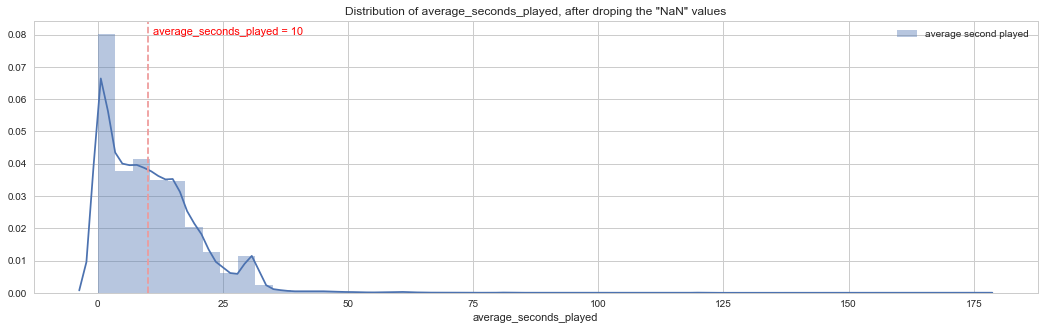

In [139]:
avg_sec = df['average_seconds_played'].copy().dropna()
fig, ax = plt.subplots(figsize=(w_img,h_img))
sns.distplot(avg_sec, ax= ax, label= 'average second played');
plt.title('Distribution of average_seconds_played, after droping the "NaN" values')
plt.legend();
p1 = plt.axvline(x=10,color='#EF9A9A', linestyle='--');
plt.text(11, 0.08, 'average_seconds_played = 10', color ='red', fontsize=11);
plt.show();

- *There is a large amount of observation with unknown users, and thus, a large amount of observations with 'NaN' values in the column **average_seconds_played**.*
- *Even the known user which don't have a 'NaN' in the average_seconds_played have usually seen ad videos for 0s.*
- *There is a part of users that have usually seen ad videos for more than 10s.*
- *There is a small amount of observations with missing values in the **user_device** columns (8 lines). We will drop them later. We won't drop the 'NaN' values from **average_seconds_played** column though, we will process it differently in the next sections.*

# Preleminary Questions

##### 1) The margin being defined as (revenue - cost) / revenue, what is our global margin based on this log?

In [141]:
print('The Global Margin Profit of the log file is : {0:.4f}%'.format((
    df['revenue'].sum() - df['cost'].sum()) * 100 / df['revenue'].sum()))

The Global Margin Profit of the log file is : 27.1907%


##### 2) Can you think of other interesting metrics to optimize?

We can optimize of the following metrics along side with the Gross profit margin:

- The first metric we can think of is the **net profit**, which gives us a clear estimation about the raw profit of the log file, or for each OS category :
<center>$Profit = Revenue - Cost$</center>

- Similarly to the gross profit margin, we can think of the **ROAS** margin : **Return On Advertising Spend**, as calculated by :
<center>$ROAS = \frac{Revenue \, from \, Ad.}{Cost \, of \, Ad.}$</center>
It measures the efficacy of a digital advertising campaign, similar to the Gross Profit margin.

- We must also take into account the volume: the **market share** for each type of OS user, materialized by the percentage of video presented for each type of user.
<center>$Market \, share = \% \frac{Number \, of \, videos \, displayed \, for \, a \, unique \, user \, OS \, category}{Total \, number \, of \, videos \, displayed}$</center>
This gives us a clear idea about the most potentially profitable market parts among the different devices.

- One other important metric we would like to optimize would be the **Customer Lifetime Value** or the **CLTV** metric. It allows us to analyze acquisition strategy and estimate marketing costs. Roughly defined, CLTV is the projected revenue that a customer will generate during their lifetime, or, as expressed in its simplistic version of equation (many variants exist):
<center>$CLTV = m * (\frac{r}{1 + i - r})$</center>
Whereas :
  - m = Gross profit margin or contribution per customer.
  - r = Customer (yearly) retention rate, or in our case, the average seconds played per video, per customer.
  - i = yearly discount rate, or the interest rate used for calculating the present value of future cash flow.

In our example, we lack of yearly indexes and information, but it would be relevant to optimize this metric.

##### 3) What are the most profitable Operating Systems?

To answer this question, we will refer first to the **Gross Profit Margin**, as calculated globally before.

In [143]:
profitable_OS = df.groupby('user_operating_system').sum()[['revenue', 'cost'
                                                           ]].sort_values(
                                                               by='revenue',
                                                               ascending=False)

profitable_OS['profit'] = (profitable_OS['revenue'] - profitable_OS['cost'])
profitable_OS['margin'] = (profitable_OS['revenue'] - profitable_OS['cost']
                           ) / profitable_OS['revenue']

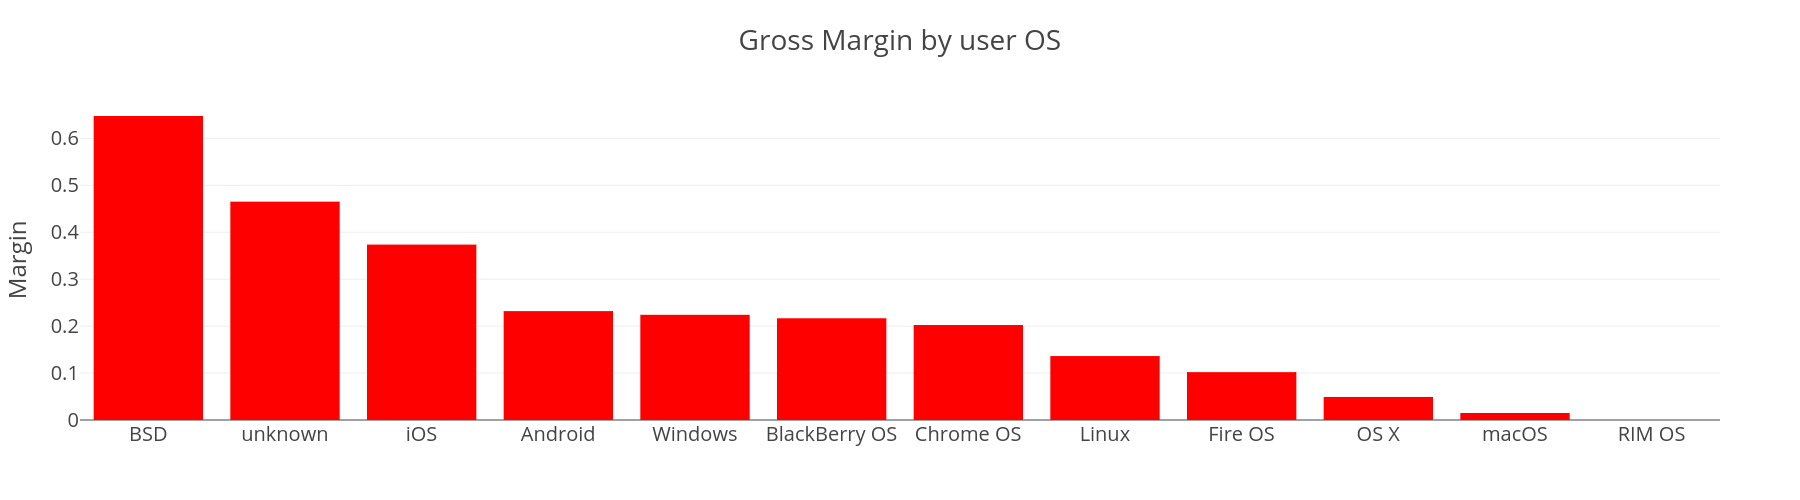

In [147]:
profitable_OS = profitable_OS.sort_values(by="margin", ascending=False)
data = [
    go.Bar(
        x=profitable_OS.index,
        y=profitable_OS['margin'],
        marker=dict(color='red'))
]
layout = go.Layout(title='Gross Margin by user OS', yaxis=dict(title='Margin'), font=dict(size=20))
fig = {'data': data, 'layout': layout}

py.image.ishow(fig, height=h_img*100, width=w_img*100)

#### >>> This view alone is biased, because we do not take in consideration the 'volume', or the market share, and other metrics that could show us more about the profit share.

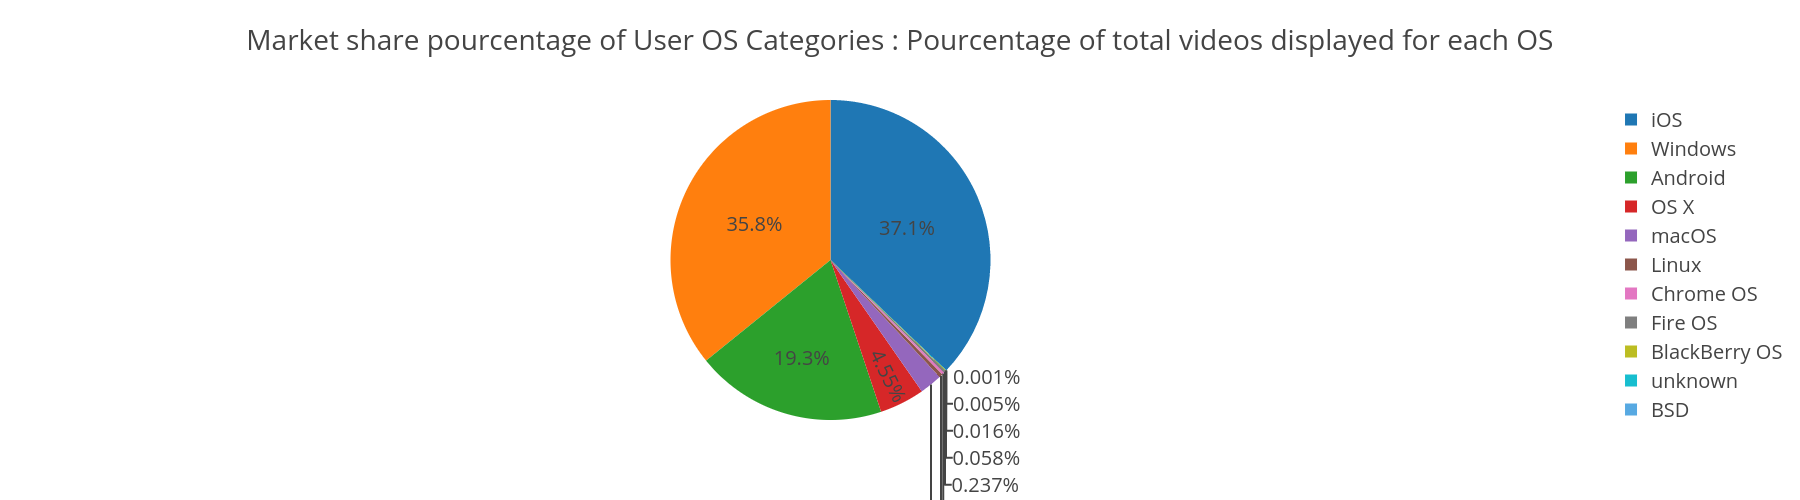

In [149]:
os_market_share = df.groupby('user_operating_system').count().revenue / df[
    'revenue'].count()

trace_device = go.Pie(labels=os_market_share.index, values=os_market_share)

layout = go.Layout(
    title=
    'Market share pourcentage of User OS Categories : Pourcentage of total videos displayed for each OS',
    font=dict(size=20)
)

fig = {'data': [trace_device], 'layout': layout}
py.image.ishow(fig, width=w_img*100, height= h_img*100)

We will focus first on the market share, we observe that **IOS**, **Windows**, **Android** and **OSX** are clearly ahead with over **$96.75\%$** of the total of the market, as displayed before. Other User OS types like BSD, BlackBerry OS... are way behind the 3 leaders, taking only $0.0xxx\%$ from the total of videos displayed. It confirms that even if we have a high Gross margin rate, as shown before with BSD for example, we cannot say that it is the most profitable OS.

##### >>> But what is the difference between profit and revenue, in total for each OS?

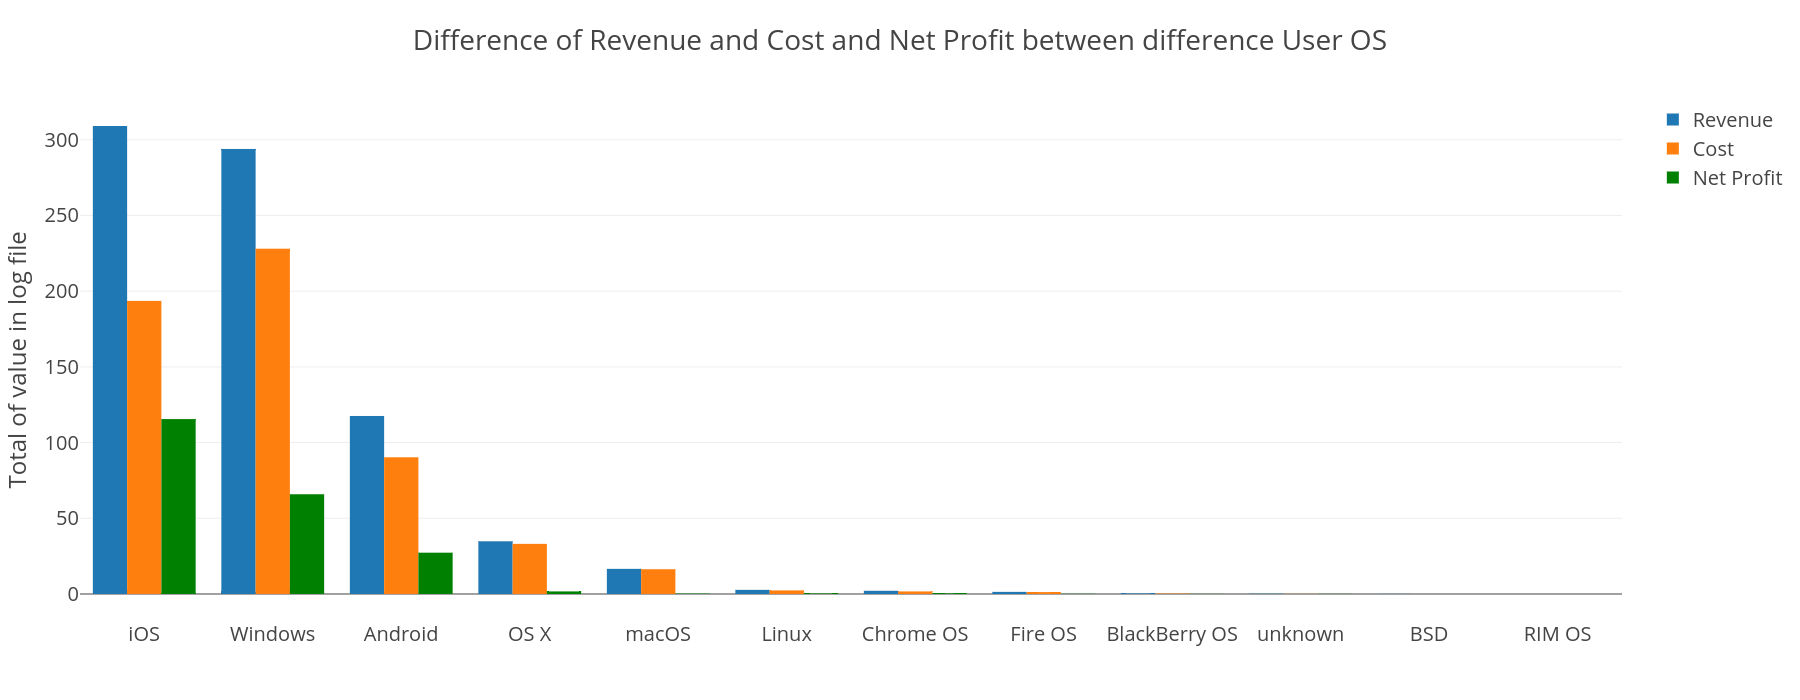

In [159]:
profitable_OS = profitable_OS.sort_values(by="revenue", ascending=False)
data = [
    go.Bar(x=profitable_OS.index, y=profitable_OS['revenue'], name='Revenue'),
    go.Bar(x=profitable_OS.index, y=profitable_OS['cost'], name='Cost'),
    go.Bar(x=profitable_OS.index, y=profitable_OS['profit'], name='Net Profit', marker=dict(color='green'))
]
layout = go.Layout(
    title='Difference of Revenue and Cost and Net Profit between difference User OS',
    yaxis=dict(title='Total of value in log file'),
    font=dict(size=20))
fig = {'data': data, 'layout': layout}

py.image.ishow(fig, width=w_img*100, height=200 + h_img*100)

#### Again, and similarly to the market share, IOS, Windows, Android and OSX stand out as the leader in term of raw profit, and raw revenues.

##### >>> How about we take a look at the user devices, and segment the Revenue/Cost view taking account this dimension?

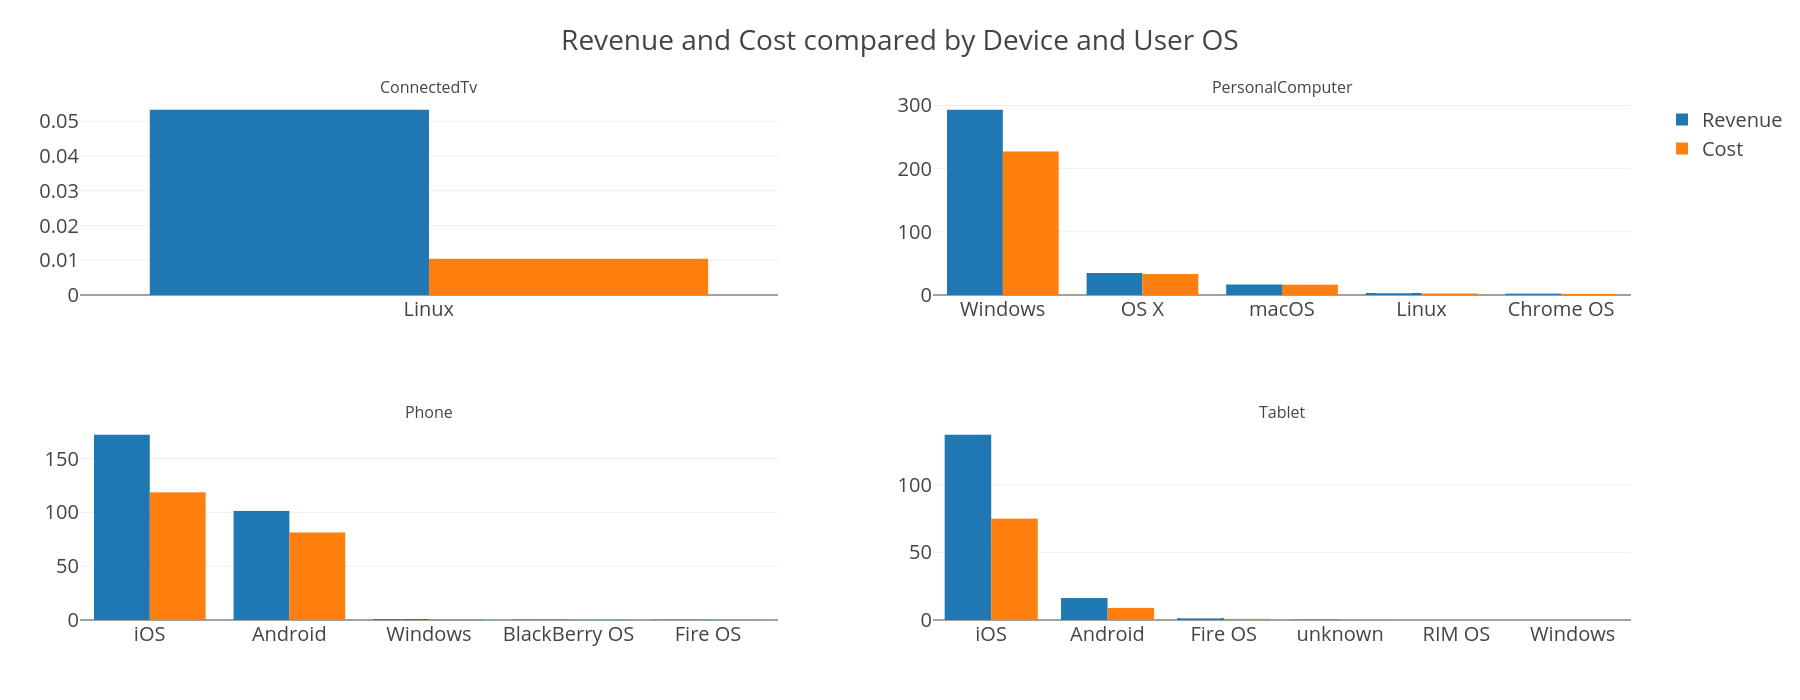

In [156]:
rev_cost = df.groupby(['user_device',
                       'user_operating_system']).sum()[['revenue', 'cost']]

plots = []
fig = tools.make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(list(rev_cost.index.levels[0])),
    print_grid=False)
plot_index = list(itertools.product([1, 2], repeat=2))

for i, device in enumerate(list(rev_cost.index.levels[0])):
    df_device = rev_cost.loc[device].sort_values(by='revenue', ascending= False)
    if i == 0:
        legend = True
    else:
        legend = False
    trace_rev = go.Bar(
        x=list(df_device.index),
        y=df_device['revenue'],
        name='Revenue',
        marker=dict(color='#1f77b4'),
        showlegend=legend)
    trace_cost = go.Bar(
        x=list(df_device.index),
        y=df_device['cost'],
        name='Cost',
        marker=dict(color='#ff7f0e'),
        showlegend=legend)
    fig.append_trace(trace_rev, plot_index[i][0], plot_index[i][1])
    fig.append_trace(trace_cost, plot_index[i][0], plot_index[i][1])

fig['layout'].update(title='Revenue and Cost compared by Device and User OS', font=dict(size=20))

py.image.ishow(fig, width=w_img*100, height=200 + h_img*100)

- **IOS** and **Android** are crushing the **Phone** and **Tablet** platforms. Even though **IOS** is clearly ahead, especially in the **Tablet** industry.
- **Windows** on the other side, is clearly leading the **PersonalComputer** platform, far ahead from **OSX** and **macOS**.
- **Linux** is the monopole actor on the **ConnectedTV** spot, but the revenues are insignificant compared to the other platforms.

##### >>> Finally, can we take a look at the revenue, profit and costs in term of pourcentage, comparing each OS to the total market?

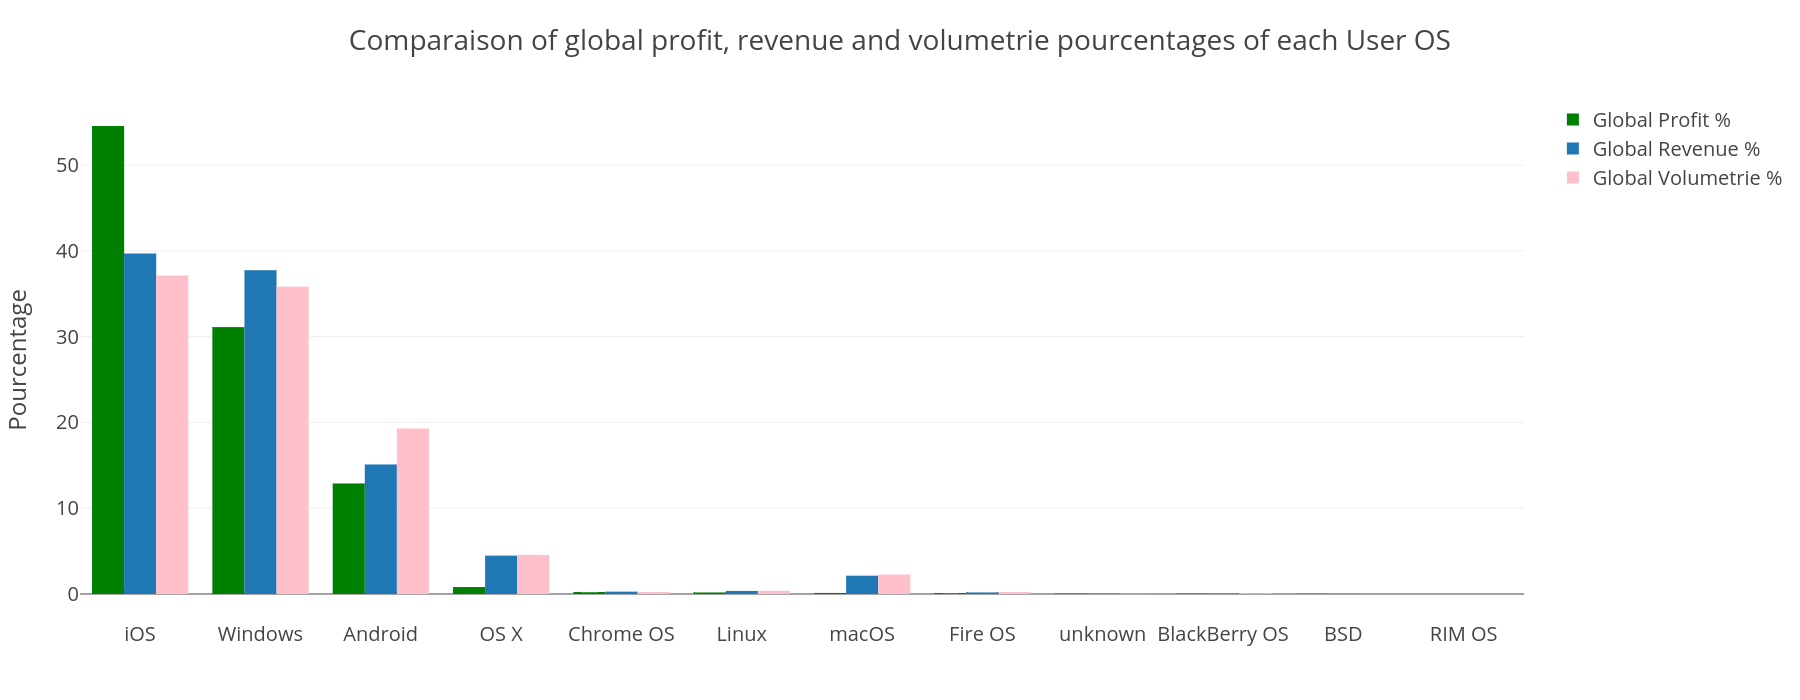

In [157]:
profits = profitable_OS['profit'] / profitable_OS['profit'].sum() * 100
revenues = df.groupby('user_operating_system').sum().revenue / df[
    'revenue'].sum() * 100
costs = df.groupby('user_operating_system').count()['creative_id']
costs = costs / costs.sum() * 100
comp_df = pd.DataFrame([revenues, costs, profits]).T.sort_values(
    by='profit', ascending=False)

data = [
    go.Bar(
        x=comp_df.index,
        y=comp_df['profit'],
        name='Global Profit %',
        marker=dict(color='green')),
    go.Bar(
        x=comp_df.index,
        y=comp_df['revenue'],
        name='Global Revenue %',
        marker=dict(color='#1f77b4')),
    go.Bar(
        x=comp_df.index,
        y=comp_df['creative_id'],
        name='Global Volumetrie %',
        marker=dict(color='pink'))
]
layout = go.Layout(
    title=
    'Comparaison of global profit, revenue and volumetrie pourcentages of each User OS',
    yaxis=dict(title='Pourcentage'), font=dict(size=20))
fig = {'data': data, 'layout': layout}

py.image.ishow(fig, width=w_img*100, height=200 + h_img*100)

### >>> We can clearly conclude that :

- **IOS**
- **Windows**
- **Android**
- **OSX**


**Are the most profitable User OS categories.**

# Machine learning questions

###### 1) How would you use this historical data to predict the event 'we benefit from a revenue' (ie revenue > 0) in a dataset where the revenue is not known yet?

- The problem is a **binary classification** problem : We want to predict either $revenue > 0$, or $revenue=0$.

- We will first generate the **'watched'** column, which constitutes our label to train our model with. We have to drop the **revenue** column then, and try to fit a well chosen classification model on the data.

In [168]:
# Create Labels
df['watched'] = np.where(df['revenue'] > 0, 1, 0)
df[['creative_id', 'revenue', 'watched']].head(20)

,creative_id,revenue,watched
0,113521,0.000000,0
1,115340,0.000000,0
2,113582,0.000000,0
3,97385,0.000000,0
4,114821,0.000000,0
5,113065,0.000000,0
6,111414,0.000000,0
7,111414,0.000000,0
8,112705,0.000000,0
9,113176,0.000000,0


###### 2) Compute the prediction accuracy of a well chosen algorithm and comment the results. Do not hesitate to describe your methodology.

- It is important then to **clean the data** : we have to handle the **'NaN'** values in the **average_seconds_played** with some way that would not bias the dataset, and we cannot drop those observations because it is not really missing data.
- The next step will be generating **relevant features** to the problematic. The purpose is to get the maximum of information that will explain the data and its relation to the labels.
- We have also to handle **categorical data** in order to feed it to the ML algorithm. We have to turn each categorical column to numerical values, by using a **OneHotEncoder**, or **Dummy variables**.
- We have to chose a **relevant optimization metric** to categorize a good classification output from the model.
- We have to pick a **classification learning algorithm** who fits well to the categorized data.
- It is also important to **standardize** and **scale** the data, and handle the **imbalanced data**.
- We will then split our data to **train** and **test** parts, and train a model on the **train_data** (with **cross validation** and some **regularization** to avoid **overfiting**) and validate it with the chosen metric to optimize on the test data.
- Finally, we will optimize the model, by **tuning** the **hyper-parameters** of the model with a **grid search** on a range of possible values.

In [224]:
# ML libraries imports
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV

**We generate new features based on the stated columns and we clean the 'average_seconds_played' from 'NaN' values :**
- We add a column 'viewer_type' which contains 0 if 'average_seconds_played' == 'NaN', 1 if  0 <='average_seconds_played' < 10 and 2 if 'average_seconds_played' > 10
- We add a column 'known_viewer' which contains 0 if 'average_seconds_played' == 'NaN', else : 1 
- We fill the 'average_seconds_played' column with zeroes instead of 'N/A' values.
- We add the mean of revenues per video, and the mean of 'average_seconds_played' per video.

In [243]:
# Re-import data
df = pd.read_csv(path + "aft100k.csv")

# Create Labels
df['watched'] = np.where(df['revenue'] > 0, 1, 0)

# We replace the 'NaN' in the dataframe with 'N/A' for
# preprocessing simplification
df['average_seconds_played'] = df['average_seconds_played'].fillna('N/A')

# We add a column 'viewer_type' which contains 0 if
# 'average_seconds_played' == 'NaN', 1 if  0 <='average_seconds_played' < 10
# and 2 if 'average_seconds_played' > 10
df['viewer_type'] = df['average_seconds_played'].apply(
    lambda x: 0 if x == 'N/A' else (1 if x >= 0 and x < 10 else 2))

# We add a column 'known_viewer' which contains 0 if 
# 'average_seconds_played' == 'NaN', else : 1 
df['known_viewer'] = df['average_seconds_played'].apply(
    lambda x: 0 if x == 'N/A' else 1)

# We fill the 'average_seconds_played' column with zeroes instead
# of 'N/A' values.
df = df.replace('N/A', 0)
df = df.dropna()

# We add the mean of revenues per video, and the mean of
# 'average_seconds_played' per video.
cost_rev_vid = df.groupby('creative_id').mean()[
    'revenue'].reset_index().rename(columns={'revenue': 'avg_revenue_vid'})
avg_sec_vid = df.groupby(
    'creative_id').mean()['average_seconds_played'].reset_index().rename(
        columns={'average_seconds_played': 'mean_avg_sec_vid'})
# Merging the new features
df = df.merge(cost_rev_vid, on='creative_id')
df = df.merge(avg_sec_vid, on='creative_id')

print("The columns of dataframe with the new features :")
print(df.columns)

The dataframe with the new features :
Index(['creative_id', 'user_operating_system', 'user_device',
       'average_seconds_played', 'cost', 'revenue', 'watched', 'viewer_type',
       'known_viewer', 'avg_revenue_vid', 'mean_avg_sec_vid'],
      dtype='object')


**Is our data balanced?**


We saw that the distribution of revenues tends to be highly concentrated over 0, which created an imbalance in the dataset (high amount of y = 0). This creates an imbalance in the signal, and our model will struggle to get the difference between the two classes.

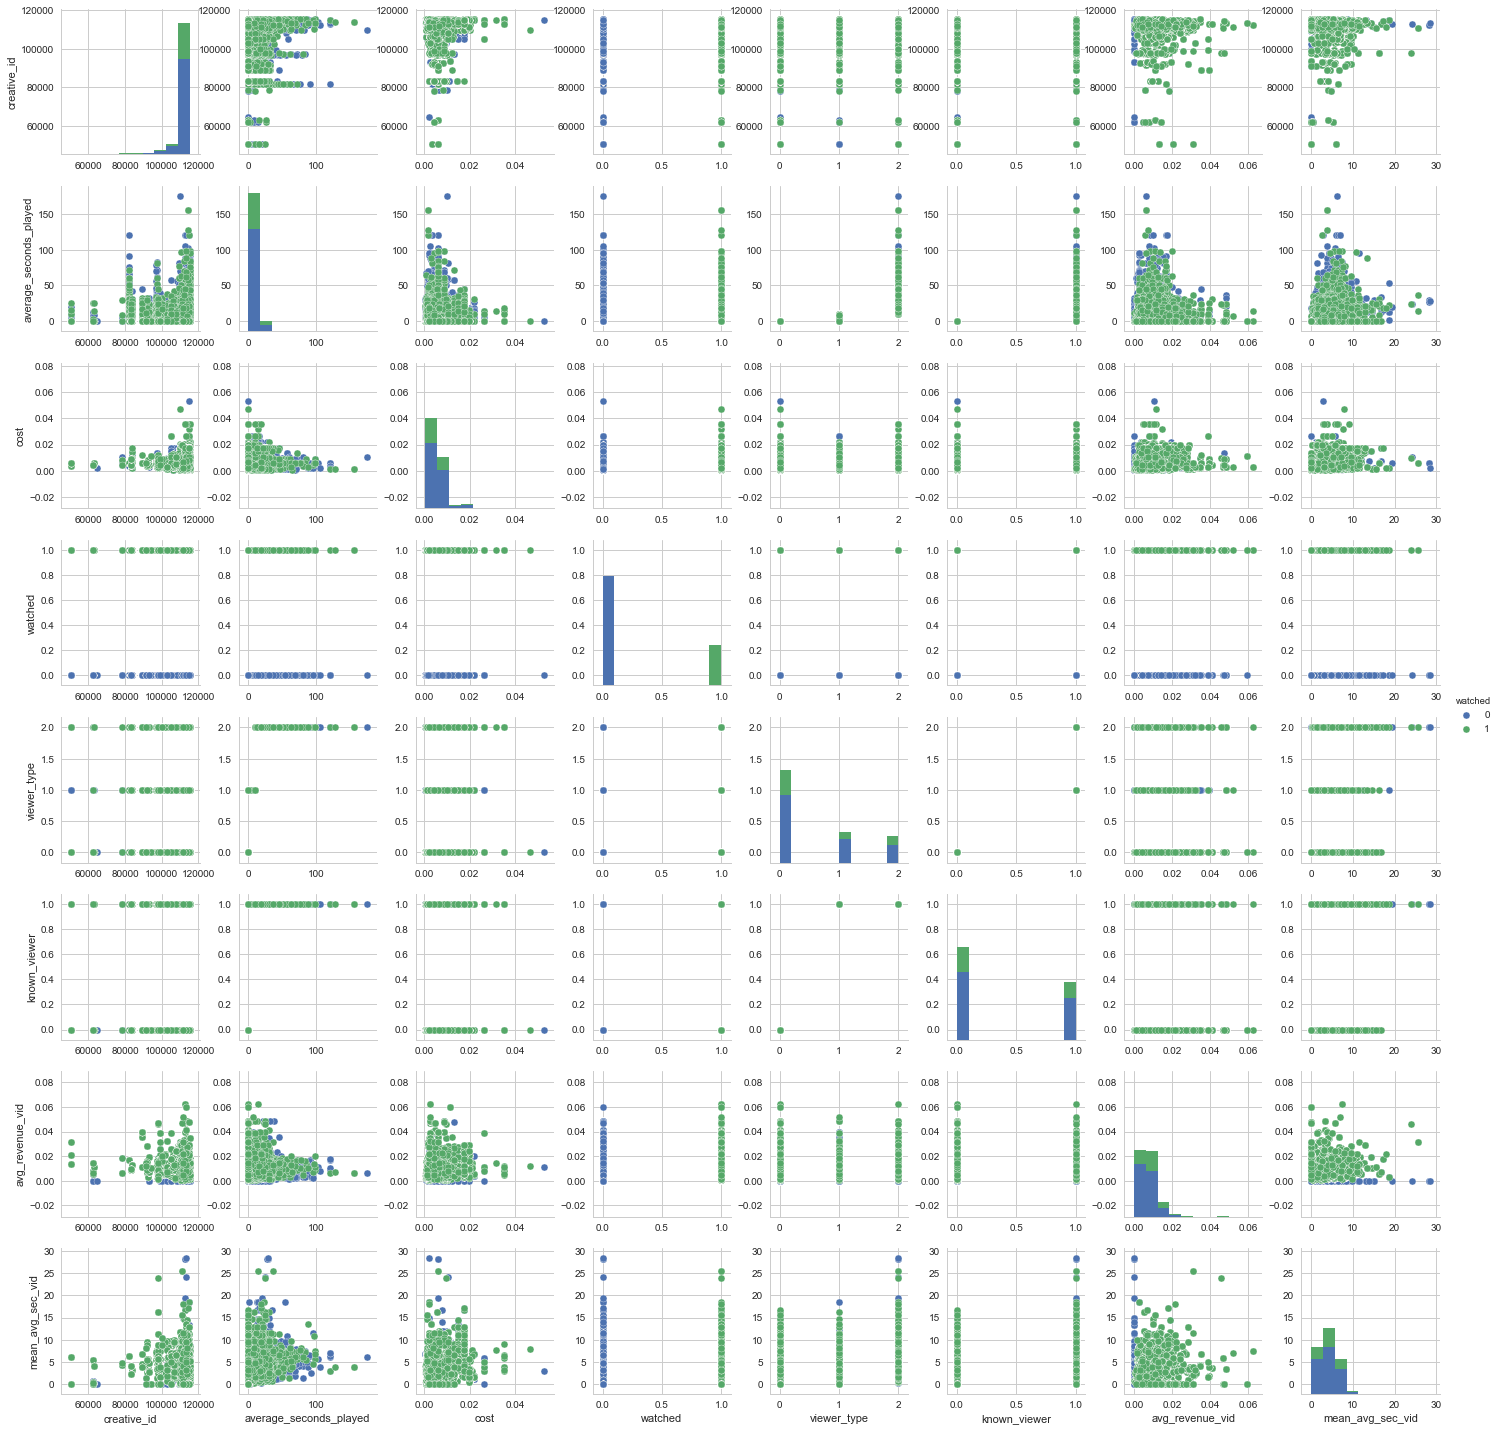

In [172]:
sns.pairplot(df.drop('revenue', axis=1), hue='watched');

###### >>> Our data is indeed imbalanced.

- We will proceed to generating new samples from the minority class (here the y=1, or revenue>0) from the existing dataset with the **bootstrap upsampling** technique. It will enhance the signal of the minority class into the model, without changing the characteristics of the data (the distributions) too much.

In [175]:
def generate_bootstraped_data(df):
    # Separate majority and minority classes
    df_minority = df[df.watched == 1]
    df_majority = df[df.watched == 0]

    # Upsample minority class
    df_minority_upsampled = resample(
        df_minority,
        replace=True,  # sample with replacement
        n_samples=df_majority.shape[0],  # to match majority class
        random_state=0)  # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print("New Upsampled data classes count : {}.".format(df_upsampled.watched.value_counts()))
    return df_upsampled

# Creating the upsampled data.
df_upsampled = generate_bootstraped_data(df)
print("New size of dataset : {}".format(df_upsampled.shape[0]))

New Upsampled data classes count : 1    72951
0    72951
Name: watched, dtype: int64.
New size of dataset : 145902


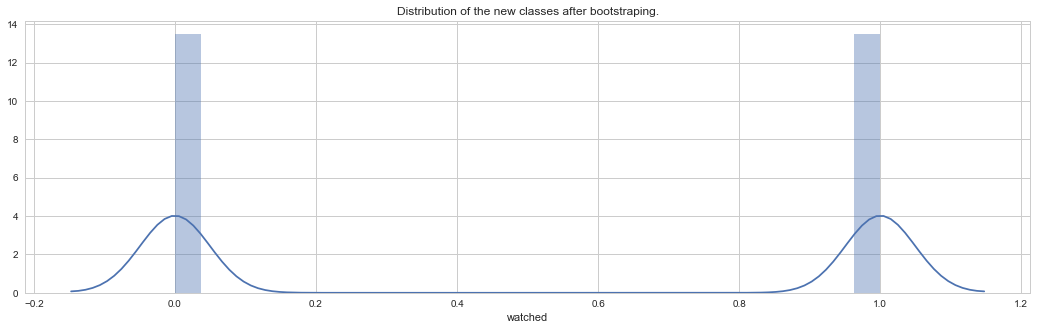

In [179]:
fig, ax = plt.subplots(figsize=(w_img,h_img))
sns.distplot(df_upsampled['watched']);
plt.title('Distribution of the new classes after bootstraping.');
plt.show()

**We will now handle the categorical data columns. We will use *Dummy variables* to generate new numerical features based on each category. **

In [244]:
df_c = df_upsampled.copy()
drop_columns = ['creative_id', 'revenue']
categorical_columnns = ['user_operating_system', 'user_device']
df_c = df_c.drop(drop_columns, axis=1)
df_c = pd.get_dummies(data=df_c, columns=categorical_columnns)
print('Features with dummy variables : {}'.format(df_c.columns))

Features with dummy variables : Index(['average_seconds_played', 'cost', 'watched', 'viewer_type',
       'known_viewer', 'avg_revenue_vid', 'mean_avg_sec_vid',
       'user_operating_system_Android', 'user_operating_system_BlackBerry OS',
       'user_operating_system_Chrome OS', 'user_operating_system_Fire OS',
       'user_operating_system_Linux', 'user_operating_system_OS X',
       'user_operating_system_RIM OS', 'user_operating_system_Windows',
       'user_operating_system_iOS', 'user_operating_system_macOS',
       'user_operating_system_unknown', 'user_device_ConnectedTv',
       'user_device_PersonalComputer', 'user_device_Phone',
       'user_device_Tablet'],
      dtype='object')


**We split the data on train and test with a 80%-20% ratio. We also apply a Standard Scaler on the train and test sets.** 

In [180]:
# Spliting to train and test
X_train, X_test, y_train, y_test = train_test_split(
    df_c[df_c.columns[df_c.columns != 'watched']],
    df_c['watched'],
    test_size=0.2,
    random_state=0)

# Apply Standard Scaler to the data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

##### >>> We will use a RandomForestClassifier to handle the modelisation task.

Reasons for choosing RF among other machine learning algorithms : 
- It is generally better in accuracy among current algorithms.
- It runs efficiently on large datasets.
- It can handle thousands of input variables or features without variable deletion.
- It gives estimates of what variables are important in the classification.
- It generates an internal unbiased estimate of the generalization error as the forest building progresses.
- It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
- It has methods for balancing error in class population unbalanced data sets.

*-**Note** : I tried first a **Logistic Regression** for a first try, then moved to a **Random Forest** for better performance.*

Parameters of our first Random Forest model RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False): 
RF AUC score on train : 0.8001581196725515
RF AUC score on test0.73146329717649: 
We can identify that the model is far from overfitting when observing the AUC train score, and also slightly under-performing on the test set.
What about feature importances generated from the model?


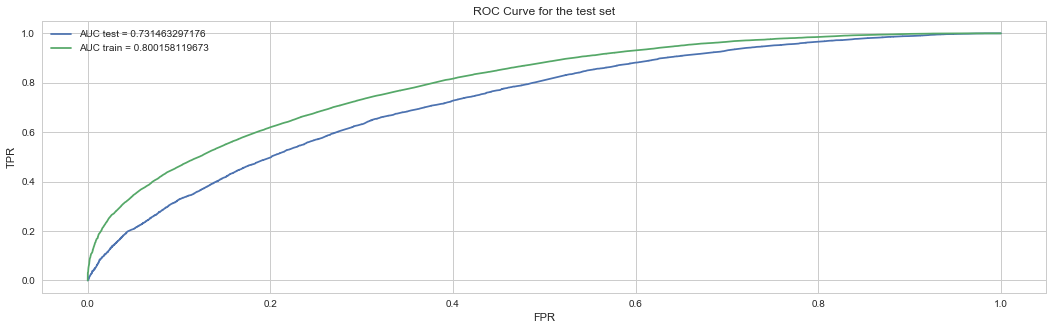

The mean average revenue per video, the mean average seconds per unique video, the average seconds per video and the cost are the most important features for the model. The categorical columns seem to have a small impact on our predictions. It means that the most impacting information for the prediction is : is the video already popular and generatinga considerable revenue?


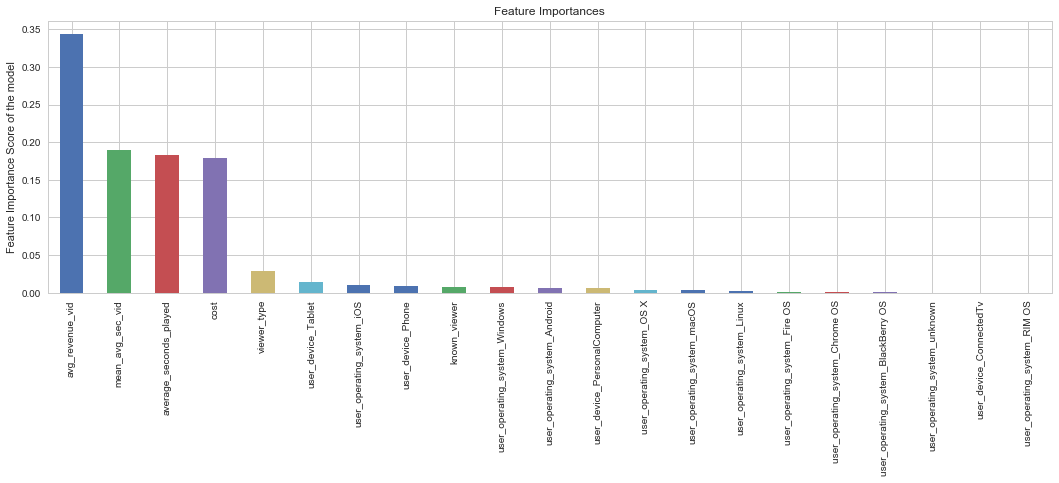

We chech the distribution of probabilities to make sure that the predictions are indeed balanced, and the signal is slightly the same for the two classes :


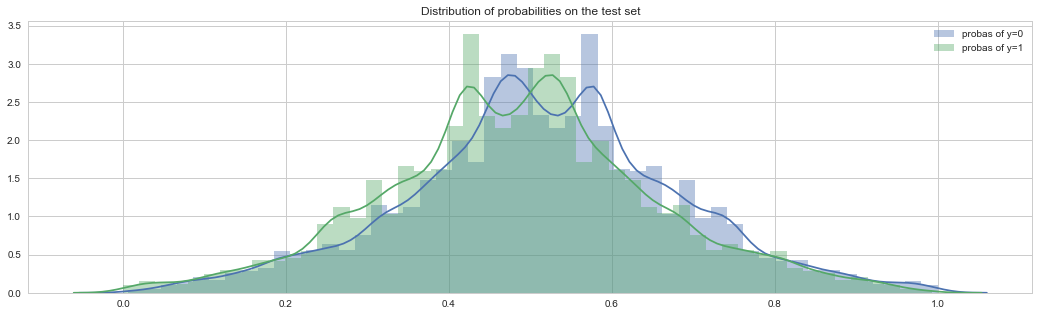

Finally, we check the Confusion matrix on the test set for our model :


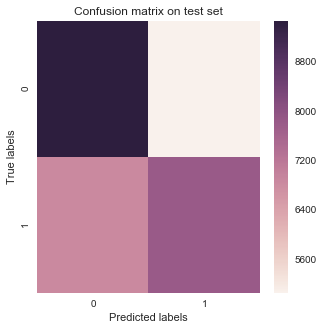

Its seems that our model does not struggle with classify y=0. It means that the model is well trained to detect a none profitable video. Although, the model is confued with the class y=1, and makes a strongly present type-2 error with a high presence of false negative predictions.


In [241]:
# Setting target and ID variables to refactor code, and
# predictors as an array of features we use for the prediction.
target = 'watched'
IDcol = 'creative_id'
predictors = [x for x in df_c.columns if x not in [target, IDcol]]

# Our first model with max_depth=15 and n_estimators=20
rf = RandomForestClassifier(n_jobs=-1, max_depth=15, n_estimators=20)
print(("Parameters of our first Random Forest model {}: ".format(rf)))

# fit the model
rf.fit(X_train_std, y_train)

# Calculating AUC scores on train and test
y_probas_train = rf.predict_proba(X_train_std)
false_positive_rate_train, true_positive_rate_train, thresholds_train = roc_curve(
    y_train, y_probas_train[:, 1])
roc_auc_train = auc(false_positive_rate_train, true_positive_rate_train)

y_probas = rf.predict_proba(X_test_std)
false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, y_probas[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print(('RF AUC score on train : {}'.format(roc_auc_train)))
print(('RF AUC score on test{}: '.format(roc_auc)))

print('We can identify that the model is far from overfitting when observing the AUC train score, '
      'and also slightly under-performing on the test set.')

print('What about feature importances generated from the model?')
fig, ax = plt.subplots(figsize=(w_img, h_img))
plt.plot(
    false_positive_rate, true_positive_rate, label='AUC test = ' + str(roc_auc));
plt.plot(
    false_positive_rate_train, true_positive_rate_train, label='AUC train = ' + str(roc_auc_train));
plt.title('ROC Curve for the test set');
plt.legend();
plt.ylabel('TPR');
plt.xlabel('FPR');
plt.show();
print('The mean average revenue per video, the mean average seconds per '
      'unique video, the average seconds per video and the cost are the '
      'most important features for the model. The categorical columns seem '
      'to have a small impact on our predictions. It means that the most impacting '
      'information for the prediction is : is the video already popular and generating'
      'a considerable revenue?')

feat_imp = pd.Series(rf.feature_importances_)
feat_imp.index = predictors
feat_imp = feat_imp.sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(w_img, h_img))
feat_imp.plot(kind='bar', title='Feature Importances', ax=ax);
plt.ylabel('Feature Importance Score of the model');
plt.show();

print('We chech the distribution of probabilities to make sure that the predictions are '
      'indeed balanced, and the signal is slightly the same for the two classes :')
fig, ax = plt.subplots(figsize=(w_img, h_img));
sns.distplot(y_probas[:,0], label='probas of y=0');
sns.distplot(y_probas[:,1], label='probas of y=1');
plt.title("Distribution of probabilities on the test set");
plt.legend();
plt.show();

print('Finally, we check the Confusion matrix on the test set for our model :')
fig, ax = plt.subplots(figsize=(h_img, h_img));
sns.heatmap(confusion_matrix(y_test, y_pred));
plt.title('Confusion matrix on test set');
plt.ylabel('True labels');
plt.xlabel('Predicted labels')
plt.show()
print('Its seems that our model does not struggle with classify y=0. It means that '
      'the model is well trained to detect a none profitable video. Although, the '
      'model is confued with the class y=1, and makes a strongly present type-2 error '
      'with a high presence of false negative predictions.')

##### >>> We will now tune our algorithm. We will perform a grid search with cross validation.

- The grid search doesn't contain a large number of parameters to avoid heavy computation necessities.
- We will cross validate the data on 3 folds (cv = 3), in order to avoid over-fitting, and reduce variance between models.
- We make sure that the metric of scoring is the AUC when performing the grid search.

In [26]:
# use a full grid over all parameters
param_grid = {
    "max_depth": [15, 20, 25],
    "n_estimators": [20, 500, 1000],
    "n_jobs": [2]
}

clf = RandomForestClassifier()
# run grid search with 'roc_auc' metric, and cv=3
grid_search = GridSearchCV(clf, param_grid=param_grid, verbose=10, n_jobs=2, cv=3, scoring='roc_auc')
grid_results = grid_search.fit(X_train_std, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] n_estimators=20, n_jobs=2, max_depth=15 .........................
[CV] n_estimators=20, n_jobs=2, max_depth=15 .........................
[CV]  n_estimators=20, n_jobs=2, max_depth=15, score=0.727860 -   1.8s
[CV] n_estimators=20, n_jobs=2, max_depth=15 .........................
[CV]  n_estimators=20, n_jobs=2, max_depth=15, score=0.724499 -   1.8s
[CV] n_estimators=500, n_jobs=2, max_depth=15 ........................


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.0s


[CV]  n_estimators=20, n_jobs=2, max_depth=15, score=0.730792 -   1.5s
[CV] n_estimators=500, n_jobs=2, max_depth=15 ........................
[CV]  n_estimators=500, n_jobs=2, max_depth=15, score=0.732768 -  53.6s
[CV] n_estimators=500, n_jobs=2, max_depth=15 ........................


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   55.7s


[CV]  n_estimators=500, n_jobs=2, max_depth=15, score=0.729712 -  55.0s
[CV] n_estimators=1000, n_jobs=2, max_depth=15 .......................
[CV]  n_estimators=500, n_jobs=2, max_depth=15, score=0.736985 -  53.1s
[CV] n_estimators=1000, n_jobs=2, max_depth=15 .......................
[CV]  n_estimators=1000, n_jobs=2, max_depth=15, score=0.733193 - 1.7min
[CV] n_estimators=1000, n_jobs=2, max_depth=15 .......................
[CV]  n_estimators=1000, n_jobs=2, max_depth=15, score=0.730226 - 1.7min
[CV] n_estimators=20, n_jobs=2, max_depth=20 .........................
[CV]  n_estimators=20, n_jobs=2, max_depth=20, score=0.748142 -   2.1s
[CV] n_estimators=20, n_jobs=2, max_depth=20 .........................


[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  3.6min


[CV]  n_estimators=20, n_jobs=2, max_depth=20, score=0.744661 -   2.3s
[CV] n_estimators=20, n_jobs=2, max_depth=20 .........................
[CV]  n_estimators=20, n_jobs=2, max_depth=20, score=0.750747 -   2.2s
[CV] n_estimators=500, n_jobs=2, max_depth=20 ........................
[CV]  n_estimators=1000, n_jobs=2, max_depth=15, score=0.736968 - 1.7min
[CV] n_estimators=500, n_jobs=2, max_depth=20 ........................
[CV]  n_estimators=500, n_jobs=2, max_depth=20, score=0.752178 -  53.9s
[CV] n_estimators=500, n_jobs=2, max_depth=20 ........................
[CV]  n_estimators=500, n_jobs=2, max_depth=20, score=0.750160 -  52.7s
[CV] n_estimators=1000, n_jobs=2, max_depth=20 .......................


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  5.2min


[CV]  n_estimators=500, n_jobs=2, max_depth=20, score=0.755044 -  48.9s
[CV] n_estimators=1000, n_jobs=2, max_depth=20 .......................
[CV]  n_estimators=1000, n_jobs=2, max_depth=20, score=0.752427 - 1.9min
[CV] n_estimators=1000, n_jobs=2, max_depth=20 .......................
[CV]  n_estimators=1000, n_jobs=2, max_depth=20, score=0.750028 - 1.9min
[CV] n_estimators=20, n_jobs=2, max_depth=25 .........................
[CV]  n_estimators=20, n_jobs=2, max_depth=25, score=0.751777 -   2.4s
[CV] n_estimators=20, n_jobs=2, max_depth=25 .........................
[CV]  n_estimators=20, n_jobs=2, max_depth=25, score=0.750016 -   2.6s
[CV] n_estimators=20, n_jobs=2, max_depth=25 .........................
[CV]  n_estimators=20, n_jobs=2, max_depth=25, score=0.753209 -   2.7s
[CV] n_estimators=500, n_jobs=2, max_depth=25 ........................
[CV]  n_estimators=500, n_jobs=2, max_depth=25, score=0.755824 - 1.2min


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  8.6min


[CV] n_estimators=500, n_jobs=2, max_depth=25 ........................
[CV]  n_estimators=1000, n_jobs=2, max_depth=20, score=0.755016 - 2.0min
[CV] n_estimators=500, n_jobs=2, max_depth=25 ........................
[CV]  n_estimators=500, n_jobs=2, max_depth=25, score=0.753888 -  58.9s
[CV] n_estimators=1000, n_jobs=2, max_depth=25 .......................
[CV]  n_estimators=500, n_jobs=2, max_depth=25, score=0.757421 - 1.0min
[CV] n_estimators=1000, n_jobs=2, max_depth=25 .......................
[CV]  n_estimators=1000, n_jobs=2, max_depth=25, score=0.755772 - 2.1min
[CV] n_estimators=1000, n_jobs=2, max_depth=25 .......................
[CV]  n_estimators=1000, n_jobs=2, max_depth=25, score=0.753983 - 2.0min
[CV]  n_estimators=1000, n_jobs=2, max_depth=25, score=0.757657 - 1.5min


[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  27 out of  27 | elapsed: 13.2min finished


Results of the grid seach cv :


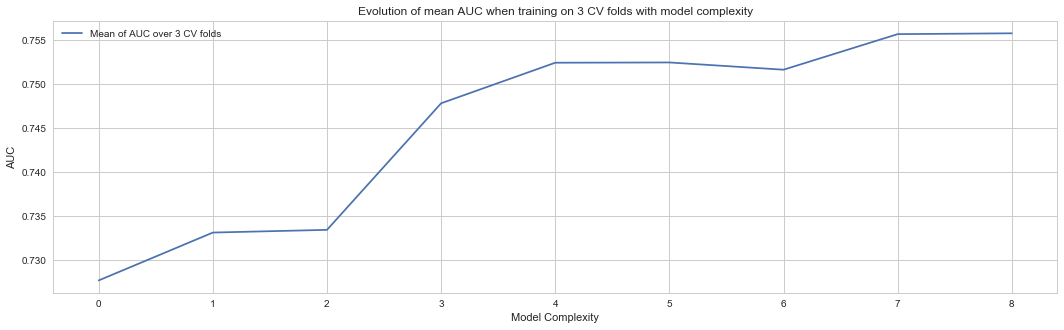

[mean: 0.72772, std: 0.00257, params: {'n_estimators': 20, 'n_jobs': 2, 'max_depth': 15},
 mean: 0.73316, std: 0.00298, params: {'n_estimators': 500, 'n_jobs': 2, 'max_depth': 15},
 mean: 0.73346, std: 0.00276, params: {'n_estimators': 1000, 'n_jobs': 2, 'max_depth': 15},
 mean: 0.74785, std: 0.00249, params: {'n_estimators': 20, 'n_jobs': 2, 'max_depth': 20},
 mean: 0.75246, std: 0.00200, params: {'n_estimators': 500, 'n_jobs': 2, 'max_depth': 20},
 mean: 0.75249, std: 0.00204, params: {'n_estimators': 1000, 'n_jobs': 2, 'max_depth': 20},
 mean: 0.75167, std: 0.00131, params: {'n_estimators': 20, 'n_jobs': 2, 'max_depth': 25},
 mean: 0.75571, std: 0.00144, params: {'n_estimators': 500, 'n_jobs': 2, 'max_depth': 25},
 mean: 0.75580, std: 0.00150, params: {'n_estimators': 1000, 'n_jobs': 2, 'max_depth': 25}]

In [232]:
print("Results of the grid seach cv :")

mean_scores = [score[1] for score in grid_search.grid_scores_]
fig, ax = plt.subplots(figsize=(w_img, h_img))
plt.plot(mean_scores, label="Mean of AUC over 3 CV folds");
plt.xlabel('Model Complexity');
plt.ylabel('AUC');
plt.title('Evolution of mean AUC when training on 3 CV folds with model complexity')
plt.legend();
plt.show();

grid_search.grid_scores_

##### >>> The perfomance of our model has slightly improven. However, the score is not seemingly high.

**Some ideas to improve the model :**
- Add data observation to the dataset, especially with profitable ads to avoid an imbalanced dataset.
- Choose a better performing Algorithm with more complexity: We can think of XGboost, or a MultiLayerPerceptron (Neuronal network).
- Add other relevant features that better explain the profitability of an ad. This can lead us to a leap in performance if the new features explain well the classification problem.
- Try with a larger set of hyperparameter values : extend the grid search will improve the overall tuning of the algorithm.
- Add some regularization to generalize the model, and avoid overfitting.

# End.

---